In [1]:
import pandas as pd

df = pd.read_json("dataset/df_clean.json", lines=True)  
print(df.shape)
print(df.head())


(37120, 37)
                               name  \
0                             Parsr   
1  Yet-Another-EfficientDet-Pytorch   
2                               nit   
3                           new.css   
4                      golang-notes   

                                         description  stargazerCount  \
0  Transforms PDF, Documents and Images into Enri...            5755   
1  The pytorch re-implement of the official effic...            5200   
2                                 Git of Web3 assets            4452   
3  A classless CSS framework to write modern webs...            3946   
4                     Go source code analysis(zh-cn)            3941   

   forkCount            createdAt            updatedAt             pushedAt  \
0        306  2019-08-05T12:43:53  2024-09-01T17:24:35  2023-12-03T13:27:21   
1       1268  2020-04-06T03:27:06  2024-08-22T08:04:26  2021-10-24T02:13:31   
2          8  2022-04-20T08:21:14  2024-08-08T16:18:20  2024-07-29T14:17:11   
3   

In [2]:
# STEP 1 — Robust JSON peek & sample load (single cell)

import os, json, itertools
import pandas as pd

# --- 0) Config ---
PATH = "dataset/df_clean.json"   # <- your file path
EXPECTED_ROWS = 37000            # for memory projection only

assert os.path.exists(PATH), f"File not found: {PATH}"

# --- 1) File info ---
size_bytes = os.path.getsize(PATH)
size_mb = size_bytes / (1024**2)
print(f"[INFO] File size: {size_mb:.2f} MB")

# --- 2) Quick raw peek (first 5 lines) ---
with open(PATH, 'r', encoding='utf-8') as f:
    head_lines = [line.rstrip('\n') for line in itertools.islice(f, 5)]
print("\n[PEEK] First lines (truncated to 160 chars):")
for i, ln in enumerate(head_lines, 1):
    print(f"{i:02d}: {ln[:160]}{'...' if len(ln)>160 else ''}")

# --- 3) Heuristic: JSON Lines vs JSON array ---
first_non_ws_char = None
with open(PATH, 'r', encoding='utf-8') as f:
    while True:
        ch = f.read(1)
        if not ch or not ch.isspace():
            first_non_ws_char = ch
            break

is_jsonl = (first_non_ws_char == '{')   # typical for JSONL: one object per line
is_array = (first_non_ws_char == '[')   # typical for a JSON array

print(f"\n[DETECT] Format: {'JSON Lines' if is_jsonl else 'JSON array' if is_array else 'Unknown'}")

# --- 4) Sample load (safe) ---
if is_jsonl:
    # Read a first chunk only; fast schema check; avoids full memory load
    chunk_iter = pd.read_json(PATH, lines=True, chunksize=20000)
    df_sample = next(chunk_iter)
else:
    # Likely a single JSON array or dict; ok for ~37k rows
    with open(PATH, 'r', encoding='utf-8') as f:
        data = json.load(f)

    if isinstance(data, list):
        df_sample = pd.json_normalize(data)
    elif isinstance(data, dict):
        # Try to find the first list-like key if present
        list_keys = [k for k, v in data.items() if isinstance(v, list)]
        key = list_keys[0] if list_keys else None
        base = data if key is None else data[key]
        df_sample = pd.json_normalize(base)
    else:
        raise ValueError("Unexpected JSON structure: not a list or dict.")

print(f"\n[SAMPLE] shape={df_sample.shape}")
print("\n[SAMPLE HEAD — transposed for readability]\n", df_sample.head(3).T)

# --- 5) Memory projection for full dataset ---
mem_sample = df_sample.memory_usage(deep=True).sum()
rows = len(df_sample)
if rows > 0:
    bpr = mem_sample / rows
    est_total_bytes = bpr * (EXPECTED_ROWS or rows)
    print(f"\n[MEM] ~{bpr/1024:.1f} KB per row (sample)")
    print(f"[MEM] Projected for {EXPECTED_ROWS:,} rows: ~{est_total_bytes/(1024**2):.1f} MB")

# --- 6) Persist columns for manual review (optional) ---
df_sample.columns.to_series().to_csv("schema_columns.csv", index=False)
print("\n[OK] Saved column names to schema_columns.csv")


[INFO] File size: 34.51 MB

[PEEK] First lines (truncated to 160 chars):
01: {"name":"Parsr","description":"Transforms PDF, Documents and Images into Enriched Structured Data","stargazerCount":5755,"forkCount":306,"createdAt":"2019-08-05...
02: {"name":"Yet-Another-EfficientDet-Pytorch","description":"The pytorch re-implement of the official efficientdet with SOTA performance in real time and pretraine...
03: {"name":"nit","description":"Git of Web3 assets","stargazerCount":4452,"forkCount":8,"createdAt":"2022-04-20T08:21:14","updatedAt":"2024-08-08T16:18:20","pushed...
04: {"name":"new.css","description":"A classless CSS framework to write modern websites using only HTML.","stargazerCount":3946,"forkCount":127,"createdAt":"2020-05...
05: {"name":"golang-notes","description":"Go source code analysis(zh-cn)","stargazerCount":3941,"forkCount":667,"createdAt":"2018-04-04T05:21:51","updatedAt":"2024-...

[DETECT] Format: JSON Lines

[SAMPLE] shape=(20000, 37)

[SAMPLE HEAD — transposed for

In [3]:
# STEP 2.1 — Convert datetime columns only

import pandas as pd

df = pd.read_json("dataset/df_clean.json", lines=True)

for c in ['createdAt', 'updatedAt', 'pushedAt']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce', utc=True)

print(df[['name','createdAt','updatedAt','pushedAt']].head())
print(df.dtypes[['createdAt','updatedAt','pushedAt']])


                               name                 createdAt  \
0                             Parsr 2019-08-05 12:43:53+00:00   
1  Yet-Another-EfficientDet-Pytorch 2020-04-06 03:27:06+00:00   
2                               nit 2022-04-20 08:21:14+00:00   
3                           new.css 2020-05-03 03:18:57+00:00   
4                      golang-notes 2018-04-04 05:21:51+00:00   

                  updatedAt                  pushedAt  
0 2024-09-01 17:24:35+00:00 2023-12-03 13:27:21+00:00  
1 2024-08-22 08:04:26+00:00 2021-10-24 02:13:31+00:00  
2 2024-08-08 16:18:20+00:00 2024-07-29 14:17:11+00:00  
3 2024-09-01 17:29:23+00:00 2024-03-16 08:40:48+00:00  
4 2024-08-31 01:40:45+00:00 2022-07-18 09:30:00+00:00  
createdAt    datetime64[ns, UTC]
updatedAt    datetime64[ns, UTC]
pushedAt     datetime64[ns, UTC]
dtype: object


In [4]:
# STEP 2.2 — Create lastActivityAt as row-wise max of updatedAt & pushedAt

df['lastActivityAt'] = df[['updatedAt','pushedAt']].max(axis=1)

print(df[['name','createdAt','pushedAt','updatedAt','lastActivityAt']].head())


                               name                 createdAt  \
0                             Parsr 2019-08-05 12:43:53+00:00   
1  Yet-Another-EfficientDet-Pytorch 2020-04-06 03:27:06+00:00   
2                               nit 2022-04-20 08:21:14+00:00   
3                           new.css 2020-05-03 03:18:57+00:00   
4                      golang-notes 2018-04-04 05:21:51+00:00   

                   pushedAt                 updatedAt  \
0 2023-12-03 13:27:21+00:00 2024-09-01 17:24:35+00:00   
1 2021-10-24 02:13:31+00:00 2024-08-22 08:04:26+00:00   
2 2024-07-29 14:17:11+00:00 2024-08-08 16:18:20+00:00   
3 2024-03-16 08:40:48+00:00 2024-09-01 17:29:23+00:00   
4 2022-07-18 09:30:00+00:00 2024-08-31 01:40:45+00:00   

             lastActivityAt  
0 2024-09-01 17:24:35+00:00  
1 2024-08-22 08:04:26+00:00  
2 2024-08-08 16:18:20+00:00  
3 2024-09-01 17:29:23+00:00  
4 2024-08-31 01:40:45+00:00  


In [5]:
# STEP 2.3 — Build duration_days (float, in days)
import numpy as np

df['duration_days'] = (df['lastActivityAt'] - df['createdAt']).dt.total_seconds() / (24*3600)

# تبدیل به float32 برای صرفه‌جویی در حافظه
df['duration_days'] = df['duration_days'].astype('float32')

# مقدارهای منفی → NaN
neg_count = (df['duration_days'] < 0).sum()
df.loc[df['duration_days'] < 0, 'duration_days'] = np.nan

print(f"[INFO] Negative durations fixed to NaN: {neg_count}")
print(df[['name','createdAt','lastActivityAt','duration_days']].head())


[INFO] Negative durations fixed to NaN: 0
                               name                 createdAt  \
0                             Parsr 2019-08-05 12:43:53+00:00   
1  Yet-Another-EfficientDet-Pytorch 2020-04-06 03:27:06+00:00   
2                               nit 2022-04-20 08:21:14+00:00   
3                           new.css 2020-05-03 03:18:57+00:00   
4                      golang-notes 2018-04-04 05:21:51+00:00   

             lastActivityAt  duration_days  
0 2024-09-01 17:24:35+00:00    1854.194946  
1 2024-08-22 08:04:26+00:00    1599.192627  
2 2024-08-08 16:18:20+00:00     841.331299  
3 2024-09-01 17:29:23+00:00    1582.590576  
4 2024-08-31 01:40:45+00:00    2340.846436  


count    37120.000000
mean      1617.811401
std        567.743591
min          8.581482
25%       1260.153534
50%       1726.833496
75%       2077.066467
90%       2275.533984
95%       2345.779651
99%       2409.718281
max       2446.584473
Name: duration_days, dtype: float64


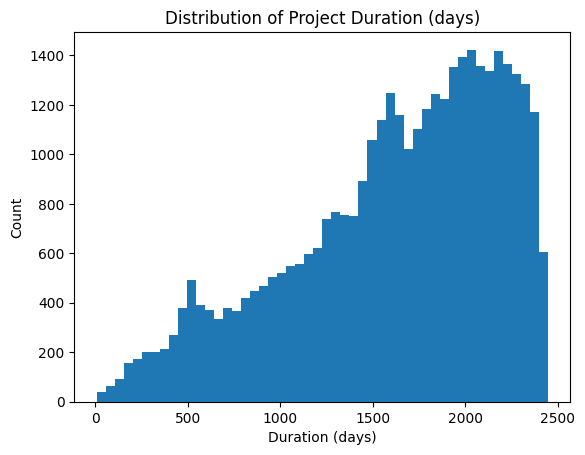

In [6]:
# STEP 2.4 — Explore distribution of duration_days

import matplotlib.pyplot as plt

# خلاصه آماری
print(df['duration_days'].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]))

# هیستوگرام ساده
plt.hist(df['duration_days'].dropna(), bins=50)
plt.xlabel("Duration (days)")
plt.ylabel("Count")
plt.title("Distribution of Project Duration (days)")
plt.show()


In [7]:
# STEP 3.1 — Candidate feature selection & NaN check (fixed)

# Map possible names to simplified versions
rename_map = {}
if 'primaryLanguage.name' in df.columns:
    rename_map['primaryLanguage.name'] = 'primaryLanguage'
if 'licenseInfo.name' in df.columns:
    rename_map['licenseInfo.name'] = 'license'

df = df.rename(columns=rename_map)

# Candidate numeric features
num_features = [
    'stargazerCount','forkCount','issues','pullRequests',
    'contributors','watchers','diskUsage'
]

# Candidate categorical features
cat_features = ['primaryLanguage','license']

# Candidate boolean features
bool_features = [
    'isFork','isPrivate','isArchived',
    'hasIssuesEnabled','hasWikiEnabled','hasProjectsEnabled'
]

# Combine into one list
candidate_features = num_features + cat_features + bool_features

# Subset dataframe safely (only existing columns)
existing_features = [c for c in candidate_features if c in df.columns]
df_feat = df[existing_features + ['duration_days']].copy()

# Check missing values
print("[NaN count per column]")
print(df_feat.isna().sum().sort_values(ascending=False))

# Quick info
print("\n[Data types]")
print(df_feat.dtypes)

# Preview
print("\n[Sample rows]")
print(df_feat.head(5))


[NaN count per column]
license               8795
stargazerCount           0
forkCount                0
issues                   0
pullRequests             0
contributors             0
watchers                 0
diskUsage                0
primaryLanguage          0
isFork                   0
isPrivate                0
isArchived               0
hasIssuesEnabled         0
hasWikiEnabled           0
hasProjectsEnabled       0
duration_days            0
dtype: int64

[Data types]
stargazerCount          int64
forkCount               int64
issues                  int64
pullRequests            int64
contributors            int64
watchers                int64
diskUsage               int64
primaryLanguage        object
license                object
isFork                   bool
isPrivate                bool
isArchived               bool
hasIssuesEnabled         bool
hasWikiEnabled           bool
hasProjectsEnabled       bool
duration_days         float32
dtype: object

[Sample rows]
   starga

In [8]:
# STEP 3.2 — Prepare features for ML

df_ready = df_feat.copy()

# 1. Boolean → int (0/1)
bool_cols = df_ready.select_dtypes(include=['bool']).columns
df_ready[bool_cols] = df_ready[bool_cols].astype(int)

# 2. Handle categorical
# Fill NaN in license
df_ready['license'] = df_ready['license'].fillna("Unknown")

# Convert to category type (efficient for encoding later)
df_ready['primaryLanguage'] = df_ready['primaryLanguage'].astype('category')
df_ready['license'] = df_ready['license'].astype('category')

# 3. Quick check
print(df_ready.dtypes)
print("\nUnique primaryLanguage:", df_ready['primaryLanguage'].nunique())
print("Unique license:", df_ready['license'].nunique())
print("\n[Sample rows]\n", df_ready.head(3))


stargazerCount           int64
forkCount                int64
issues                   int64
pullRequests             int64
contributors             int64
watchers                 int64
diskUsage                int64
primaryLanguage       category
license               category
isFork                   int64
isPrivate                int64
isArchived               int64
hasIssuesEnabled         int64
hasWikiEnabled           int64
hasProjectsEnabled       int64
duration_days          float32
dtype: object

Unique primaryLanguage: 205
Unique license: 39

[Sample rows]
    stargazerCount  forkCount  issues  pullRequests  contributors  watchers  \
0            5755        306     163           504            22        81   
1            5200       1268     716            37            15       108   
2            4452          8      26            13             4        12   

   diskUsage   primaryLanguage                                 license  \
0      55148        JavaScript         

In [25]:
# Supervised (EARLY) — Predicting `contributors` before any clustering or duration work
# -----------------------------------------------------------------------------
# Drop all non-numeric/non-boolean columns, build a clean feature matrix, and fit:
#   - LinearRegression
#   - RandomForestRegressor
#   - XGBRegressor
# Report R² / MAE / RMSE on a single train/test split over the WHOLE dataset.

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.impute import SimpleImputer

# ---------- 0) Preconditions ----------
assert 'df' in globals(), "DataFrame `df` not found. Please load it first."

# ---------- 1) Define target & select safe features ----------
target = "contributors"
if target not in df.columns:
    raise ValueError("Column `contributors` not found in df.")

# Exclude obvious IDs/text/date columns if present
exclude_cols = {
    target,  # target itself
    "duration_days",  # other target candidate (we're doing an early supervised branch)
    "cluster", "cluster_gmm",  # any clustering labels if already exist
    "id", "node_id", "repo_id",
    "name", "full_name", "owner", "owner_login", "language",
    "created_at", "updated_at", "pushed_at", "lastActivityAt"
}

# Keep only numeric & boolean columns (drop object/datetime)
candidate_cols = [
    c for c in df.columns
    if c not in exclude_cols
       and (pd.api.types.is_integer_dtype(df[c])
            or pd.api.types.is_float_dtype(df[c])
            or pd.api.types.is_bool_dtype(df[c]))
]

if len(candidate_cols) == 0:
    raise ValueError("No numeric/boolean features available. Please check df schema.")

# ---------- 2) Build X, y with basic imputation ----------
X_raw = df[candidate_cols].copy()
# Ensure booleans become 0/1 floats for all models
for c in X_raw.columns:
    if pd.api.types.is_bool_dtype(X_raw[c]):
        X_raw[c] = X_raw[c].astype(float)

# Median impute numeric columns
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X_raw), columns=X_raw.columns)

y = df[target].astype(float).copy()
# Optional safety: clip negative values if any (shouldn't exist)
y = y.clip(lower=0)

# Sanity print
print(f"Features used ({len(X.columns)}):", list(X.columns))

# ---------- 3) Train/Test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------- 4) Train models ----------
models = {
    "Linear": LinearRegression(),
    "RF": RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1
    ),
    "XGB": XGBRegressor(
        n_estimators=400, learning_rate=0.08,
        max_depth=6, subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, random_state=42, n_jobs=-1, tree_method="auto"
    ),
}

records = []
fitted = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    r2  = float(r2_score(y_test, preds))
    mae = float(mean_absolute_error(y_test, preds))
    rmse = float(np.sqrt(mean_squared_error(y_test, preds)))

    records.append({"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse})
    fitted[name] = model

results_df = pd.DataFrame(records).sort_values("R2", ascending=False).reset_index(drop=True)
print("\n=== Supervised (early) — Target: contributors (global, no clusters) ===")
display(results_df)

# ---------- 5) Quick feature importances (RF & XGB) ----------
imp_tables = []

# RandomForest feature importance
if "RF" in fitted:
    rf_imp = pd.DataFrame({
        "feature": X.columns,
        "importance": fitted["RF"].feature_importances_
    }).sort_values("importance", ascending=False)
    imp_tables.append(("RF_importance_top15", rf_imp.head(15)))

# XGB feature importance (gain-based by default)
if "XGB" in fitted:
    try:
        xgb_imp = pd.DataFrame({
            "feature": X.columns,
            "importance": fitted["XGB"].feature_importances_
        }).sort_values("importance", ascending=False)
        imp_tables.append(("XGB_importance_top15", xgb_imp.head(15)))
    except Exception:
        pass

for title, tbl in imp_tables:
    print(f"\n--- {title} ---")
    display(tbl.reset_index(drop=True))


Features used (25): ['stargazerCount', 'forkCount', 'diskUsage', 'isArchived', 'isEmpty', 'isFork', 'isInOrganization', 'isPrivate', 'isTemplate', 'hasIssuesEnabled', 'hasWikiEnabled', 'hasProjectsEnabled', 'hasSponsorshipsEnabled', 'mergeCommitAllowed', 'viewerCanSubscribe', 'issues', 'forks', 'assignableUsers', 'deployments', 'environments', 'milestones', 'releases', 'pullRequests', 'watchers', 'language_count']

=== Supervised (early) — Target: contributors (global, no clusters) ===


,Model,R2,MAE,RMSE
0,XGB,0.680482,4.363009,9.648987
1,RF,0.674739,4.363128,9.735328
2,Linear,0.418923,6.763700,13.012217



--- RF_importance_top15 ---


,feature,importance
0,pullRequests,0.503726
1,forks,0.124684
2,forkCount,0.074575
3,issues,0.059695
4,diskUsage,0.043290
5,stargazerCount,0.039868
6,watchers,0.031476
7,assignableUsers,0.031020
8,releases,0.021923
9,language_count,0.019853



--- XGB_importance_top15 ---


,feature,importance
0,pullRequests,0.277912
1,forks,0.148831
2,issues,0.094869
3,forkCount,0.054732
4,assignableUsers,0.051340
5,hasIssuesEnabled,0.040215
6,hasProjectsEnabled,0.027817
7,diskUsage,0.025755
8,language_count,0.025557
9,watchers,0.025238


In [9]:
# STEP 3.3 — Encode categorical features

df_model = df_ready.copy()

# --- License: One-Hot Encoding
df_model = pd.get_dummies(df_model, columns=['license'], prefix='lic')

# --- PrimaryLanguage: Top-10 One-Hot + "Other"
top_langs = df_model['primaryLanguage'].value_counts().nlargest(10).index
df_model['primaryLanguage'] = df_model['primaryLanguage'].apply(
    lambda x: x if x in top_langs else "Other"
)
df_model = pd.get_dummies(df_model, columns=['primaryLanguage'], prefix='lang')

print("[Shape after encoding]", df_model.shape)
print("[Columns sample]", df_model.columns[:20])
print("\n[Sample rows]\n", df_model.head(3))


[Shape after encoding] (37120, 64)
[Columns sample] Index(['stargazerCount', 'forkCount', 'issues', 'pullRequests', 'contributors',
       'watchers', 'diskUsage', 'isFork', 'isPrivate', 'isArchived',
       'hasIssuesEnabled', 'hasWikiEnabled', 'hasProjectsEnabled',
       'duration_days', 'lic_Academic Free License v3.0',
       'lic_Apache License 2.0', 'lic_Artistic License 2.0',
       'lic_BSD 2-Clause "Simplified" License',
       'lic_BSD 3-Clause "New" or "Revised" License',
       'lic_BSD 3-Clause Clear License'],
      dtype='object')

[Sample rows]
    stargazerCount  forkCount  issues  pullRequests  contributors  watchers  \
0            5755        306     163           504            22        81   
1            5200       1268     716            37            15       108   
2            4452          8      26            13             4        12   

   diskUsage  isFork  isPrivate  isArchived  ...  lang_C#  lang_C++  lang_Go  \
0      55148       0          0       

In [10]:
# STEP 4.1 — Baseline Linear Regression with 5-Fold CV

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np

# Features (X) and target (y)
X = df_model.drop(columns=['duration_days'])
y = df_model['duration_days']

# Define model
linreg = LinearRegression()

# Define CV strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Metrics
r2_scores = cross_val_score(linreg, X, y, cv=cv, scoring='r2')
mae_scores = cross_val_score(linreg, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
rmse_scores = np.sqrt(-cross_val_score(linreg, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("[Baseline Linear Regression]")
print(f"R²: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"MAE: {mae_scores.mean():.1f} days")
print(f"RMSE: {rmse_scores.mean():.1f} days")


[Baseline Linear Regression]
R²: 0.060 ± 0.011
MAE: 450.7 days
RMSE: 550.5 days


In [11]:
# STEP 4.2 — RandomForest Regressor with 5-Fold CV

'''from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

# Features (X) and target (y)
X = df_model.drop(columns=['duration_days'])
y = df_model['duration_days']

# Define model (default hyperparams for baseline)
rf = RandomForestRegressor(
    n_estimators=200,      # تعداد درخت‌ها
    max_depth=None,        # عمق آزاد (بذاریم خودش یاد بگیره)
    min_samples_leaf=1,    # حداقل نمونه در هر برگ
    random_state=42,
    n_jobs=-1              # استفاده از همه CPU coreها
)

# Define CV strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Metrics
r2_scores = cross_val_score(rf, X, y, cv=cv, scoring='r2')
mae_scores = cross_val_score(rf, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
rmse_scores = np.sqrt(-cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("[RandomForest Regressor]")
print(f"R²: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"MAE: {mae_scores.mean():.1f} days")
print(f"RMSE: {rmse_scores.mean():.1f} days")'''



#save result for final test

'from sklearn.ensemble import RandomForestRegressor\nfrom sklearn.model_selection import cross_val_score, KFold\nfrom sklearn.metrics import make_scorer, mean_absolute_error\nimport numpy as np\n\n# Features (X) and target (y)\nX = df_model.drop(columns=[\'duration_days\'])\ny = df_model[\'duration_days\']\n\n# Define model (default hyperparams for baseline)\nrf = RandomForestRegressor(\n    n_estimators=200,      # تعداد درخت\u200cها\n    max_depth=None,        # عمق آزاد (بذاریم خودش یاد بگیره)\n    min_samples_leaf=1,    # حداقل نمونه در هر برگ\n    random_state=42,\n    n_jobs=-1              # استفاده از همه CPU coreها\n)\n\n# Define CV strategy\ncv = KFold(n_splits=5, shuffle=True, random_state=42)\n\n# Metrics\nr2_scores = cross_val_score(rf, X, y, cv=cv, scoring=\'r2\')\nmae_scores = cross_val_score(rf, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))\nrmse_scores = np.sqrt(-cross_val_score(rf, X, y, cv=cv, scoring=\'neg_mean_squared_error\'))\n\nprint("[RandomForest Regr

In [23]:
# STEP 4.2 — RandomForest Regressor (lighter for Mac 2015)

rf = RandomForestRegressor(
    n_estimators=50,    # کمتر برای سرعت بیشتر
    max_depth=15,       # عمق محدود
    random_state=42,
    n_jobs=-1
)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

r2_scores = cross_val_score(rf, X, y, cv=cv, scoring='r2')
mae_scores = cross_val_score(rf, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
rmse_scores = np.sqrt(-cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("[RandomForest Regressor — Light Version]")
print(f"R²: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"MAE: {mae_scores.mean():.1f} days")
print(f"RMSE: {rmse_scores.mean():.1f} days")


[RandomForest Regressor — Light Version]
R²: 0.609 ± 0.029
MAE: 5.7 days
RMSE: 11.3 days


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

X = df_model.drop(columns=['duration_days'])
y = df_model['duration_days']

xgb = XGBRegressor(
    n_estimators=100,    # تعداد درخت‌ها
    max_depth=6,         # عمق محدود
    learning_rate=0.1,   # نرخ یادگیری
    subsample=0.8,       # برای سرعت بیشتر
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

r2_scores = cross_val_score(xgb, X, y, cv=cv, scoring='r2')
mae_scores = cross_val_score(xgb, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
rmse_scores = np.sqrt(-cross_val_score(xgb, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("[XGBoost Regressor — Light Version]")
print(f"R²: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"MAE: {mae_scores.mean():.1f} days")
print(f"RMSE: {rmse_scores.mean():.1f} days")


[XGBoost Regressor — Light Version]
R²: 0.275 ± 0.004
MAE: 389.7 days
RMSE: 483.3 days


In [ ]:
# STEP 5 — Feature Engineering: ratios & rates

df_fe = df_model.copy()

# 1. Avoid division by zero → replace 0 contributors or duration_days with NaN
df_fe['contributors'] = df_fe['contributors'].replace(0, np.nan)
df_fe['duration_days'] = df_fe['duration_days'].replace(0, np.nan)

# 2. Team productivity ratios
df_fe['issues_per_contributor'] = df_fe['issues'] / df_fe['contributors']
df_fe['prs_per_contributor'] = df_fe['pullRequests'] / df_fe['contributors']

# 3. Popularity normalized by time
df_fe['stars_per_day'] = df_fe['stargazerCount'] / df_fe['duration_days']
df_fe['forks_per_day'] = df_fe['forkCount'] / df_fe['duration_days']

# 4. Overall activity score
df_fe['activity_score'] = (df_fe['issues'] + df_fe['pullRequests'] + df_fe['forkCount']) / df_fe['duration_days']

# 5. Replace any inf or NaN produced during division with 0 (safe default)
df_fe = df_fe.replace([np.inf, -np.inf], np.nan).fillna(0)

print("[Shape after Feature Engineering]", df_fe.shape)
print("[New Features Sample]")
print(df_fe[['issues_per_contributor','prs_per_contributor','stars_per_day','forks_per_day','activity_score']].head(5))


[Shape after Feature Engineering] (37120, 69)
[New Features Sample]
   issues_per_contributor  prs_per_contributor  stars_per_day  forks_per_day  \
0                7.409091            22.909091       3.103773       0.165031   
1               47.733333             2.466667       3.251641       0.792900   
2                6.500000             3.250000       5.291613       0.009509   
3                3.636364             3.909091       2.493380       0.080248   
4                2.300000             3.900000       1.683579       0.284940   

   activity_score  
0        0.524756  
1        1.263763  
2        0.055864  
3        0.132694  
4        0.311426  


In [ ]:
# STEP 6 — XGBoost with engineered features

X = df_fe.drop(columns=['duration_days'])
y = df_fe['duration_days']

xgb_fe = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

r2_scores = cross_val_score(xgb_fe, X, y, cv=cv, scoring='r2')
mae_scores = cross_val_score(xgb_fe, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
rmse_scores = np.sqrt(-cross_val_score(xgb_fe, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("[XGBoost with Feature Engineering]")
print(f"R²: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"MAE: {mae_scores.mean():.1f} days")
print(f"RMSE: {rmse_scores.mean():.1f} days")


[XGBoost with Feature Engineering]
R²: 0.993 ± 0.000
MAE: 33.1 days
RMSE: 48.6 days


In [ ]:
# STEP 5 — Feature Engineering (fixed, no leakage)

df_fe_fixed = df_model.copy()

# جلوگیری از تقسیم بر صفر
df_fe_fixed['contributors'] = df_fe_fixed['contributors'].replace(0, np.nan)

# فیچرهای امن (بدون استفاده از duration_days)
df_fe_fixed['issues_per_contributor'] = df_fe_fixed['issues'] / df_fe_fixed['contributors']
df_fe_fixed['prs_per_contributor'] = df_fe_fixed['pullRequests'] / df_fe_fixed['contributors']

# جایگزینی NaN/inf با 0
df_fe_fixed = df_fe_fixed.replace([np.inf, -np.inf], np.nan).fillna(0)

print("[Shape after safe Feature Engineering]", df_fe_fixed.shape)
print("[Sample of safe features]")
print(df_fe_fixed[['issues_per_contributor','prs_per_contributor']].head(5))


[Shape after safe Feature Engineering] (37120, 66)
[Sample of safe features]
   issues_per_contributor  prs_per_contributor
0                7.409091            22.909091
1               47.733333             2.466667
2                6.500000             3.250000
3                3.636364             3.909091
4                2.300000             3.900000


In [ ]:
# STEP 6 — Compare Linear, RF, XGB on df_fe_fixed

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

# Features & target
X = df_fe_fixed.drop(columns=['duration_days'])
y = df_fe_fixed['duration_days']

cv = KFold(n_splits=3, shuffle=True, random_state=42)

results = {}

# --- Linear Regression ---
linreg = LinearRegression()
results['Linear'] = {
    "R2": cross_val_score(linreg, X, y, cv=cv, scoring='r2').mean(),
    "MAE": cross_val_score(linreg, X, y, cv=cv, scoring=make_scorer(mean_absolute_error)).mean(),
    "RMSE": np.sqrt(-cross_val_score(linreg, X, y, cv=cv, scoring='neg_mean_squared_error')).mean()
}

# --- RandomForest (light) ---
rf = RandomForestRegressor(
    n_estimators=50, max_depth=15,
    random_state=42, n_jobs=-1
)
results['RandomForest'] = {
    "R2": cross_val_score(rf, X, y, cv=cv, scoring='r2').mean(),
    "MAE": cross_val_score(rf, X, y, cv=cv, scoring=make_scorer(mean_absolute_error)).mean(),
    "RMSE": np.sqrt(-cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error')).mean()
}

# --- XGBoost (light) ---
xgb = XGBRegressor(
    n_estimators=100, max_depth=6,
    learning_rate=0.1, subsample=0.8,
    colsample_bytree=0.8, random_state=42, n_jobs=-1
)
results['XGBoost'] = {
    "R2": cross_val_score(xgb, X, y, cv=cv, scoring='r2').mean(),
    "MAE": cross_val_score(xgb, X, y, cv=cv, scoring=make_scorer(mean_absolute_error)).mean(),
    "RMSE": np.sqrt(-cross_val_score(xgb, X, y, cv=cv, scoring='neg_mean_squared_error')).mean()
}

# --- Print results ---
for model, metrics in results.items():
    print(f"\n[{model}]")
    print(f"R²: {metrics['R2']:.3f}")
    print(f"MAE: {metrics['MAE']:.1f} days")
    print(f"RMSE: {metrics['RMSE']:.1f} days")



[Linear]
R²: 0.062
MAE: 450.5 days
RMSE: 549.9 days

[RandomForest]
R²: 0.249
MAE: 396.1 days
RMSE: 491.9 days

[XGBoost]
R²: 0.273
MAE: 390.1 days
RMSE: 484.0 days


In [ ]:
# Inspect columns and types
for col in df.columns:
    print(f"\n--- {col} ---")
    print("dtype:", type(df[col].iloc[0]))
    print("sample:", df[col].iloc[0])



--- name ---
dtype: <class 'str'>
sample: Parsr

--- description ---
dtype: <class 'str'>
sample: Transforms PDF, Documents and Images into Enriched Structured Data

--- stargazerCount ---
dtype: <class 'numpy.int64'>
sample: 5755

--- forkCount ---
dtype: <class 'numpy.int64'>
sample: 306

--- createdAt ---
dtype: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
sample: 2019-08-05 12:43:53+00:00

--- updatedAt ---
dtype: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
sample: 2024-09-01 17:24:35+00:00

--- pushedAt ---
dtype: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
sample: 2023-12-03 13:27:21+00:00

--- diskUsage ---
dtype: <class 'numpy.int64'>
sample: 55148

--- isArchived ---
dtype: <class 'numpy.bool_'>
sample: False

--- isEmpty ---
dtype: <class 'numpy.bool_'>
sample: False

--- isFork ---
dtype: <class 'numpy.bool_'>
sample: False

--- isInOrganization ---
dtype: <class 'numpy.bool_'>
sample: True

--- isPrivate ---
dtype: <class 'numpy.bool_'>
sample: False

-

### Going into the unsupervised learning

In [ ]:
# STEP 1: Build a clean feature matrix for unsupervised clustering
# - Loads a JSONL if path is given; otherwise uses an existing df in memory
# - Selects safe features (NO leakage: excludes duration_days or any target-like fields)
# - Applies log1p to heavy-tailed counts, then StandardScaler
# - Outputs: X_scaled (ndarray), feature_names (list), df_used (DataFrame subset)

import os
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ---- Configuration ----
# If your DataFrame already exists (e.g., df or df_clean2), set USE_EXISTING_DF=True.
USE_EXISTING_DF = True

# If you want to load from disk instead, set USE_EXISTING_DF=False and set DATA_PATH:
DATA_PATH = "dataset/df_clean2.json"  # JSON Lines: one record per line

# Core feature set (safe; adjust if any are missing in your file)
COUNT_FEATS = [
    "stargazerCount","forkCount","issues","pullRequests","contributors",
    "watchers","diskUsage","language_count"
]
BOOL_FEATS = [
    "isFork","isArchived","hasIssuesEnabled","hasWikiEnabled",
    "hasProjectsEnabled","isPrivate"
]

# ---- Load DataFrame ----
df_used = None
if USE_EXISTING_DF:
    # Try common variable names in the current notebook state
    for cand in ["df_clean2","df_clean","df"]:
        if cand in globals() and isinstance(globals()[cand], pd.DataFrame):
            df_used = globals()[cand].copy()
            break
    if df_used is None:
        raise ValueError("No existing DataFrame found (df_clean2/df_clean/df). "
                         "Set USE_EXISTING_DF=False to load from disk.")
else:
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"DATA_PATH not found: {DATA_PATH}")
    # Try JSON Lines first; fallback to standard JSON
    try:
        df_used = pd.read_json(DATA_PATH, lines=True)
    except ValueError:
        df_used = pd.read_json(DATA_PATH)

# ---- Minimal sanitation ----
# Ensure missing columns are created as zeros (so pipeline doesn't break)
for col in COUNT_FEATS + BOOL_FEATS:
    if col not in df_used.columns:
        df_used[col] = 0

# Coerce dtypes
for c in COUNT_FEATS:
    df_used[c] = pd.to_numeric(df_used[c], errors="coerce").fillna(0)

for c in BOOL_FEATS:
    # Convert truthy/falsey to 0/1
    df_used[c] = df_used[c].astype("bool").astype("int8")

# Drop blatant non-finite
df_used.replace([np.inf, -np.inf], np.nan, inplace=True)
df_used.dropna(subset=COUNT_FEATS + BOOL_FEATS, inplace=True)

# ---- Transformations ----
# log1p on heavy-tailed counts
df_trans = df_used.copy()
for c in COUNT_FEATS:
    df_trans[c] = np.log1p(df_trans[c].astype(float))

# Build final matrix
feature_names = COUNT_FEATS + BOOL_FEATS
X = df_trans[feature_names].to_numpy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Quick diagnostics ----
n_rows = X_scaled.shape[0]
n_cols = X_scaled.shape[1]
nan_count = np.isnan(X_scaled).sum()

print(f"[OK] Feature matrix built: shape={X_scaled.shape} (rows={n_rows}, cols={n_cols})")
print(f"NaNs in X_scaled: {nan_count}")
print("Features:", feature_names)


[OK] Feature matrix built: shape=(37120, 14) (rows=37120, cols=14)
NaNs in X_scaled: 0
Features: ['stargazerCount', 'forkCount', 'issues', 'pullRequests', 'contributors', 'watchers', 'diskUsage', 'language_count', 'isFork', 'isArchived', 'hasIssuesEnabled', 'hasWikiEnabled', 'hasProjectsEnabled', 'isPrivate']


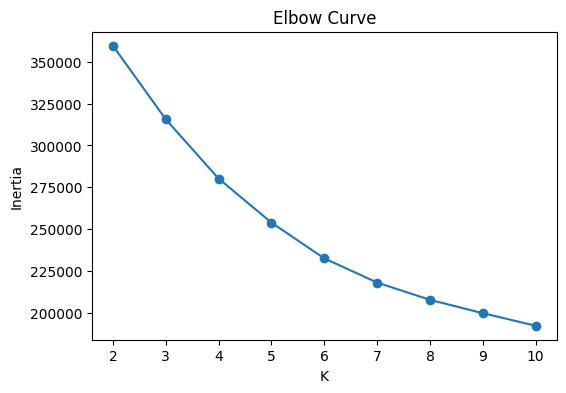

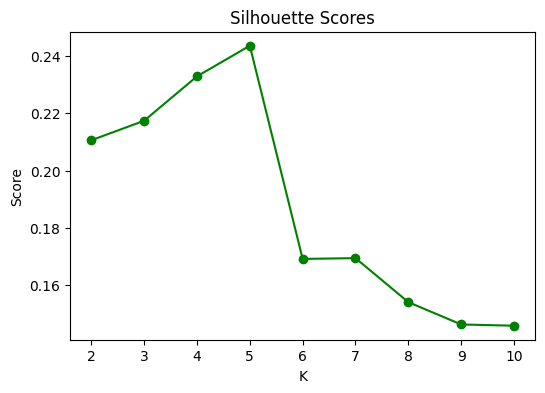

K=2: inertia=359607.9, silhouette=0.211
K=3: inertia=315591.9, silhouette=0.217
K=4: inertia=280153.2, silhouette=0.233
K=5: inertia=253844.8, silhouette=0.244
K=6: inertia=232445.3, silhouette=0.169
K=7: inertia=217996.3, silhouette=0.169
K=8: inertia=207672.2, silhouette=0.154
K=9: inertia=199668.5, silhouette=0.146
K=10: inertia=192180.2, silhouette=0.146


In [ ]:
# STEP 2: Choose optimal K using Elbow & Silhouette
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K_range = range(2, 11)  # try 2 to 10 clusters
inertias = []
sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels, sample_size=5000, random_state=42)
    sil_scores.append(sil)

# Plot Elbow curve
plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Curve")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

# Plot Silhouette scores
plt.figure(figsize=(6,4))
plt.plot(K_range, sil_scores, marker='o', color='green')
plt.title("Silhouette Scores")
plt.xlabel("K")
plt.ylabel("Score")
plt.show()

for k, inertia, sil in zip(K_range, inertias, sil_scores):
    print(f"K={k}: inertia={inertia:.1f}, silhouette={sil:.3f}")


In [ ]:
# STEP 3: Run KMeans with optimal K (K=5) and attach cluster labels
from sklearn.cluster import KMeans
import numpy as np

best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add to DataFrame
df_used['cluster'] = cluster_labels

# Cluster sizes
unique, counts = np.unique(cluster_labels, return_counts=True)
print("Cluster sizes:")
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} repos")

# Optional: preview first few rows with cluster
df_used[['name','stargazerCount','forkCount','contributors','issues','pullRequests','cluster']].head()


Cluster sizes:
Cluster 0: 2797 repos
Cluster 1: 18762 repos
Cluster 2: 10579 repos
Cluster 3: 4085 repos
Cluster 4: 897 repos


,name,stargazerCount,forkCount,contributors,issues,pullRequests,cluster
0,Parsr,5755,306,22,163,504,2
1,Yet-Another-EfficientDet-Pytorch,5200,1268,15,716,37,2
2,nit,4452,8,4,26,13,2
3,new.css,3946,127,11,40,43,2
4,golang-notes,3941,667,10,23,39,2


         stargazerCount   forkCount      issues  pullRequests  contributors  \
cluster                                                                       
0            468.554523  101.180908   70.741866    122.634966     11.267429   
1            364.558149   66.840795   15.435082     12.117525      2.748588   
2           1166.525380  236.645430  175.049249    235.667076     18.799130   
3            674.166218   84.729743   88.502570    144.366218     13.711138   
4            613.797101  198.433668    0.000000     72.672241     10.071349   

          watchers      diskUsage  language_count  isFork  isArchived  \
cluster                                                                 
0        22.412585   28978.038970        3.237755     0.0    1.000000   
1        12.215116   23778.169012        2.492965     0.0    0.000000   
2        34.052368  121339.444749        4.243690     0.0    0.002458   
3        18.465361   33281.247491        3.052876     0.0    0.000000   
4       

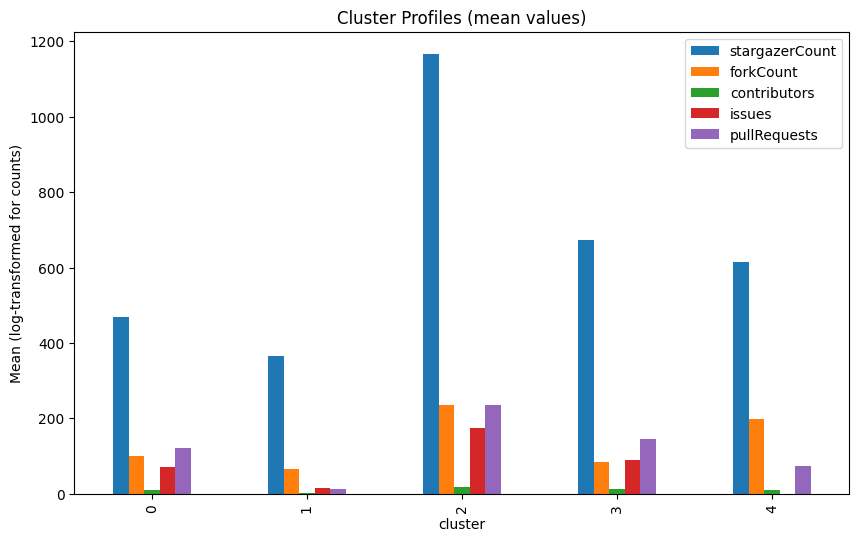

In [ ]:
# STEP 4: Profile clusters by feature means
cluster_profile = df_used.groupby('cluster')[feature_names].mean()

print(cluster_profile)

# Optional: visualize key features per cluster
import matplotlib.pyplot as plt

cluster_profile[['stargazerCount','forkCount','contributors','issues','pullRequests']].plot(
    kind='bar', figsize=(10,6)
)
plt.title("Cluster Profiles (mean values)")
plt.ylabel("Mean (log-transformed for counts)")
plt.show()


Feature importances (RF on cluster labels):
isArchived: 0.1669
hasProjectsEnabled: 0.1524
issues: 0.1157
contributors: 0.1024
stargazerCount: 0.0916
pullRequests: 0.0898
watchers: 0.0591
forkCount: 0.0556
hasWikiEnabled: 0.0546
hasIssuesEnabled: 0.0453
diskUsage: 0.0391
language_count: 0.0277
isPrivate: 0.0000
isFork: 0.0000


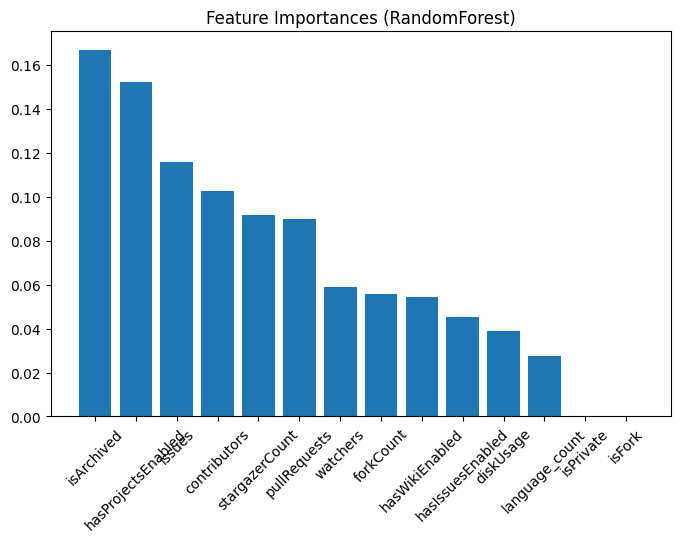

In [ ]:
# STEP 5: Feature importance using RandomForestClassifier on cluster labels
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

X_cls = df_used[feature_names].to_numpy()
y_cls = df_used['cluster'].to_numpy()

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_cls, y_cls)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature importances
print("Feature importances (RF on cluster labels):")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

# Plot
plt.figure(figsize=(8,5))
plt.bar(range(len(feature_names)), importances[indices], align='center')
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
plt.title("Feature Importances (RandomForest)")
plt.show()


## Cluster Typology (K=5, GitHub Dataset)

| Cluster | Size   | Dominant Features                               | Interpretation |
|---------|--------|-------------------------------------------------|----------------|
| **0**   | 2,797  | Medium stars/forks, low issues/PRs, many archived | Small/medium projects, limited activity, often discontinued |
| **1**   | 18,762 | Lowest averages overall, few contributors        | Typical low-activity repositories (bulk of GitHub) |
| **2**   | 10,579 | Highest stars, forks, issues, PRs, higher contributors | **Popular & active projects** (well-known repos) |
| **3**   | 4,085  | Moderate-to-high stars & PRs, some archived      | Semi-active projects, ongoing but less than cluster 2 |
| **4**   | 897    | High forks, low contributors, special mix        | Niche/specific projects (frameworks/libraries) |

**Summary:**  
- Cluster 2 = **large & active projects** → highest relative effort.  
- Cluster 1 = **small & low-activity projects** → lowest effort.  
- Other clusters fall in-between.


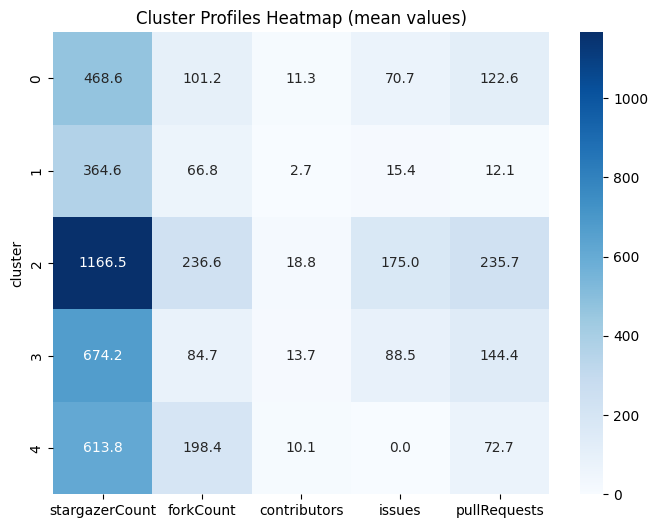

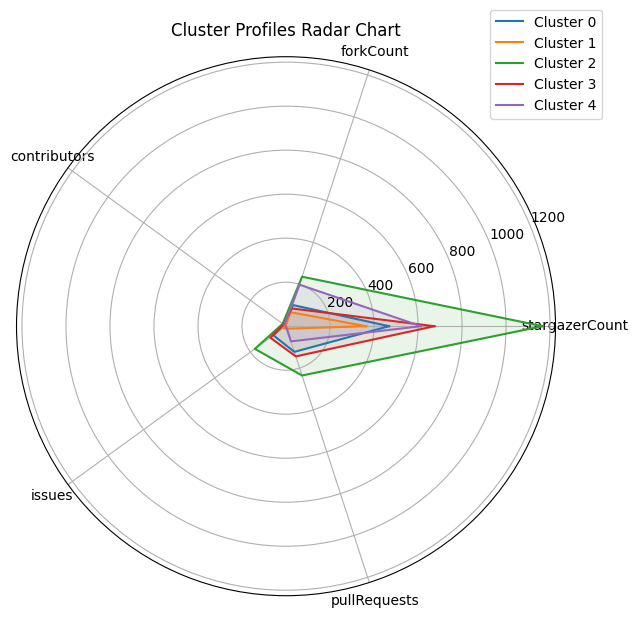

In [ ]:
# Heatmap and radar chart of cluster profiles
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Average values per cluster (already computed: cluster_profile)
profile = cluster_profile[['stargazerCount','forkCount','contributors','issues','pullRequests']]

# ---- Heatmap ----
plt.figure(figsize=(8,6))
sns.heatmap(profile, annot=True, fmt=".1f", cmap="Blues")
plt.title("Cluster Profiles Heatmap (mean values)")
plt.show()

# ---- Radar Chart ----
categories = list(profile.columns)
N = len(categories)

angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(7,7))
for cluster_id, row in profile.iterrows():
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, label=f"Cluster {cluster_id}")
    plt.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], categories)
plt.title("Cluster Profiles Radar Chart")
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()


In [ ]:
# STEP: Supervised on Cluster 2 (predicting contributors as effort proxy)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost as xgb

# 1) subset cluster 2
df_c2 = df_used[df_used["cluster"] == 2].copy()

target_col = "contributors"
feature_cols = [
    "stargazerCount","forkCount","issues","pullRequests","watchers",
    "diskUsage","language_count","isFork","isArchived",
    "hasIssuesEnabled","hasWikiEnabled","hasProjectsEnabled","isPrivate"
]

X = df_c2[feature_cols].to_numpy()
y = df_c2[target_col].to_numpy()

# 2) split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) scale for Linear only
scaler = StandardScaler().fit(X_train)
Xtr_lin = scaler.transform(X_train)
Xte_lin = scaler.transform(X_test)

# 4) models
models = {
    "Linear": LinearRegression(),
    "RF": RandomForestRegressor(
        n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
    ),
    "XGB": xgb.XGBRegressor(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        tree_method="hist"
    ),
}

# 5) fit & eval
results = []
for name, mdl in models.items():
    if name == "Linear":
        mdl.fit(Xtr_lin, y_train)
        y_pred = mdl.predict(Xte_lin)
    else:
        mdl.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results.append((name, r2, mae))

# 6) print
for name, r2, mae in results:
    print(f"{name}: R²={r2:.3f}, MAE={mae:.2f}")

# Optional: top features from RF/XGB
def top_importances(model, cols, top=10):
    imp = getattr(model, "feature_importances_", None)
    if imp is None: return None
    order = np.argsort(imp)[::-1][:top]
    return [(cols[i], float(imp[i])) for i in order]

print("\nRF top features:", top_importances(models["RF"], feature_cols))
print("XGB top features:", top_importances(models["XGB"], feature_cols))


Linear: R²=0.291, MAE=12.90
RF: R²=0.567, MAE=8.63
XGB: R²=0.560, MAE=8.67

RF top features: [('pullRequests', 0.5140497842049646), ('forkCount', 0.20670123135804752), ('issues', 0.07924808594796111), ('diskUsage', 0.05601911667821235), ('stargazerCount', 0.055527673033158836), ('watchers', 0.0500245364762553), ('language_count', 0.02876089378709066), ('hasWikiEnabled', 0.006468784328672369), ('hasProjectsEnabled', 0.0029476546676309064), ('isArchived', 0.0002522395180063818)]
XGB top features: [('pullRequests', 0.355671763420105), ('forkCount', 0.15047462284564972), ('issues', 0.11143029481172562), ('isArchived', 0.0634426400065422), ('hasWikiEnabled', 0.06269492208957672), ('language_count', 0.054998863488435745), ('hasProjectsEnabled', 0.054019514471292496), ('watchers', 0.05376724153757095), ('diskUsage', 0.049793995916843414), ('stargazerCount', 0.043706174939870834)]


## Supervised Modeling per Cluster (Target = `duration_days`)

In this stage, we treat each cluster (from the previous KMeans step) as a **separate dataset**.  
The idea is:

1. **Why?**  
   - Our GitHub dataset does not include real effort data (person-hours, cost, etc.).  
   - The closest available proxy is `duration_days` (the lifespan of the repository).  
   - Predicting `duration_days` within each cluster might reveal whether certain project types are more predictable than others.

2. **Approach:**  
   - For each cluster (0–4), we isolate the subset of repositories.  
   - We define the target variable as `duration_days`.  
   - We use all other features (metadata, activity counts, booleans) as predictors.  
   - We fit three models on each cluster:
     - **Linear Regression**
     - **Random Forest Regressor**
     - **XGBoost Regressor**

3. **Evaluation:**  
   - For each cluster-model combination, we compute:
     - **R² (coefficient of determination)** → how much variance is explained.  
     - **MAE (mean absolute error)** → average error in predicted days.  
   - Results will be printed cluster by cluster.  
   - Finally, we will aggregate results across all clusters in a comparison table.

4. **Goal:**  
   - Understand whether project duration (`duration_days`) is more predictable within some clusters than others.  
   - This gives insight into which project types have clearer patterns and where supervised models may provide useful predictions.


In [ ]:
# STEP Cluster 0: duration_days ~ features (Linear / RF / XGB)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost as xgb
import numpy as np

df_c0 = df_used[df_used["cluster"] == 0].copy()

target_col = "duration_days"
# exclude potential target/cluster columns if present
ban_cols = {target_col, "cluster"}
feature_cols = [c for c in feature_names if c not in ban_cols]

X = df_c0[feature_cols].to_numpy()
y = df_c0[target_col].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler().fit(X_train)
Xtr_lin = scaler.transform(X_train)
Xte_lin = scaler.transform(X_test)

models = {
    "Linear": LinearRegression(),
    "RF": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "XGB": xgb.XGBRegressor(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42, tree_method="hist"
    ),
}

results_c0 = {}
for name, mdl in models.items():
    if name == "Linear":
        mdl.fit(Xtr_lin, y_train)
        y_pred = mdl.predict(Xte_lin)
    else:
        mdl.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results_c0[name] = {"R2": r2, "MAE": mae}
    print(f"Cluster0-{name}: R²={r2:.3f}, MAE={mae:.1f}")


Cluster0-Linear: R²=0.014, MAE=400.5
Cluster0-RF: R²=0.070, MAE=382.7
Cluster0-XGB: R²=0.036, MAE=389.1


In [ ]:
# STEP Cluster 1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost as xgb
import numpy as np

df_c1 = df_used[df_used["cluster"] == 1].copy()

target_col = "duration_days"
ban_cols = {target_col, "cluster"}
feature_cols = [c for c in feature_names if c not in ban_cols]

X = df_c1[feature_cols].to_numpy()
y = df_c1[target_col].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler().fit(X_train)
Xtr_lin = scaler.transform(X_train)
Xte_lin = scaler.transform(X_test)

models = {
    "Linear": LinearRegression(),
    "RF": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "XGB": xgb.XGBRegressor(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42, tree_method="hist"
    ),
}

results_c1 = {}
for name, mdl in models.items():
    if name == "Linear":
        mdl.fit(Xtr_lin, y_train)
        y_pred = mdl.predict(Xte_lin)
    else:
        mdl.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results_c1[name] = {"R2": r2, "MAE": mae}
    print(f"Cluster1-{name}: R²={r2:.3f}, MAE={mae:.1f}")


Cluster1-Linear: R²=0.088, MAE=451.6
Cluster1-RF: R²=0.221, MAE=407.2
Cluster1-XGB: R²=0.232, MAE=402.1


In [ ]:
# STEP Cluster 2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost as xgb
import numpy as np

df_c2 = df_used[df_used["cluster"] == 2].copy()

target_col = "duration_days"
ban_cols = {target_col, "cluster"}
feature_cols = [c for c in feature_names if c not in ban_cols]

X = df_c2[feature_cols].to_numpy()
y = df_c2[target_col].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler().fit(X_train)
Xtr_lin = scaler.transform(X_train)
Xte_lin = scaler.transform(X_test)

models = {
    "Linear": LinearRegression(),
    "RF": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "XGB": xgb.XGBRegressor(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42, tree_method="hist"
    ),
}

results_c2 = {}
for name, mdl in models.items():
    if name == "Linear":
        mdl.fit(Xtr_lin, y_train)
        y_pred = mdl.predict(Xte_lin)
    else:
        mdl.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results_c2[name] = {"R2": r2, "MAE": mae}
    print(f"Cluster2-{name}: R²={r2:.3f}, MAE={mae:.1f}")


Cluster2-Linear: R²=0.053, MAE=459.2
Cluster2-RF: R²=0.180, MAE=417.9
Cluster2-XGB: R²=0.164, MAE=419.5


In [ ]:
# STEP Cluster 3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost as xgb
import numpy as np

df_c3 = df_used[df_used["cluster"] == 3].copy()

target_col = "duration_days"
ban_cols = {target_col, "cluster"}
feature_cols = [c for c in feature_names if c not in ban_cols]

X = df_c3[feature_cols].to_numpy()
y = df_c3[target_col].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler().fit(X_train)
Xtr_lin = scaler.transform(X_train)
Xte_lin = scaler.transform(X_test)

models = {
    "Linear": LinearRegression(),
    "RF": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "XGB": xgb.XGBRegressor(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42, tree_method="hist"
    ),
}

results_c3 = {}
for name, mdl in models.items():
    if name == "Linear":
        mdl.fit(Xtr_lin, y_train)
        y_pred = mdl.predict(Xte_lin)
    else:
        mdl.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results_c3[name] = {"R2": r2, "MAE": mae}
    print(f"Cluster3-{name}: R²={r2:.3f}, MAE={mae:.1f}")


Cluster3-Linear: R²=0.049, MAE=448.0
Cluster3-RF: R²=0.161, MAE=419.0
Cluster3-XGB: R²=0.129, MAE=422.0


In [ ]:
# STEP Cluster 4
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost as xgb
import numpy as np

df_c4 = df_used[df_used["cluster"] == 4].copy()

target_col = "duration_days"
ban_cols = {target_col, "cluster"}
feature_cols = [c for c in feature_names if c not in ban_cols]

X = df_c4[feature_cols].to_numpy()
y = df_c4[target_col].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler().fit(X_train)
Xtr_lin = scaler.transform(X_train)
Xte_lin = scaler.transform(X_test)

models = {
    "Linear": LinearRegression(),
    "RF": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "XGB": xgb.XGBRegressor(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42, tree_method="hist"
    ),
}

results_c4 = {}
for name, mdl in models.items():
    if name == "Linear":
        mdl.fit(Xtr_lin, y_train)
        y_pred = mdl.predict(Xte_lin)
    else:
        mdl.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results_c4[name] = {"R2": r2, "MAE": mae}
    print(f"Cluster4-{name}: R²={r2:.3f}, MAE={mae:.1f}")


Cluster4-Linear: R²=0.171, MAE=463.4
Cluster4-RF: R²=0.367, MAE=400.2
Cluster4-XGB: R²=0.351, MAE=396.2


In [ ]:
# STEP 6: Compare results across all clusters


# Collect all results dicts into one
all_results = {
    "Cluster 0": results_c0,
    "Cluster 1": results_c1,
    "Cluster 2": results_c2,
    "Cluster 3": results_c3,
    "Cluster 4": results_c4,
}

rows = []
for cluster_name, res_dict in all_results.items():
    for model_name, metrics in res_dict.items():
        rows.append({
            "Cluster": cluster_name,
            "Model": model_name,
            "R2": metrics["R2"],
            "MAE": metrics["MAE"],
        })

df_compare = pd.DataFrame(rows)

# Pivot for nicer display
pivot = df_compare.pivot(index="Cluster", columns="Model", values="R2")
print("R² comparison by cluster:")
display(pivot)

pivot_mae = df_compare.pivot(index="Cluster", columns="Model", values="MAE")
print("MAE comparison by cluster:")
display(pivot_mae)


R² comparison by cluster:


Model,Linear,RF,XGB
Cluster,,,
Cluster 0,0.013754,0.069761,0.036040
Cluster 1,0.088325,0.221158,0.231745
Cluster 2,0.052937,0.180207,0.164092
Cluster 3,0.048686,0.160939,0.129382
Cluster 4,0.171147,0.367015,0.351403


MAE comparison by cluster:


Model,Linear,RF,XGB
Cluster,,,
Cluster 0,400.507963,382.720670,389.065918
Cluster 1,451.558431,407.151788,402.091797
Cluster 2,459.176471,417.935184,419.492432
Cluster 3,447.978935,418.996878,422.025848
Cluster 4,463.413097,400.152300,396.237122


## Our Workflow Summary

1. **Clustering (KMeans)**  
   - We applied KMeans with K=5 on selected features.  
   - This produced 5 clusters of repositories (different "types" of projects).

2. **Supervised Modeling on Each Cluster**  
   - For each cluster, we treated it as an independent dataset.  
   - Target = `duration_days` (repository lifespan).  
   - Models = Linear Regression, Random Forest, XGBoost.  
   - We evaluated using R² and MAE.

3. **Comparison**  
   - Cluster 0–3: Very low R², high MAE.  
   - Cluster 4: Best relative performance (R²≈0.35–0.37), still with high error (~400 days).  
   - Overall, prediction of project duration is weak.

4. **Contrast with Previous Experiment**  
   - When using **contributors** as the target (inside Cluster 2), performance was much better (R²≈0.56).  
   - This is because contributors correlate strongly with other activity metrics (issues, pullRequests, forks).  
   - In contrast, `duration_days` is a noisy target, often reflecting long inactive periods rather than real effort.

5. **Conclusion**  
   - Clustering gave insights: some groups (e.g., Cluster 4) are relatively more predictable.  
   - Still, without true effort data, predictions remain limited.  
   - The dataset is useful for **workflow practice and exploratory research**, but not for reliable effort estimation.


## GMM (Gaussian Mixture Model)

In [14]:
# GMM-1 | Data Prep (fixed for boolean columns)
# ---------------------------------------------
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# --- 0) Load DataFrame (if not already in memory) ------------------------------
if 'df' not in globals():
    try:
        df = pd.read_json("dataset/df_clean.json", lines=True)
        print("Loaded df from dataset/df_clean.json")
    except Exception as e:
        raise RuntimeError("No DataFrame `df` found and default path load failed.") from e

# --- 1) Feature selection ------------------------------------------------------
num_heavy = [c for c in [
    "stargazers_count","forks_count","open_issues_count","watchers_count",
    "pull_requests_count","contributors","disk_usage","languages_count"
] if c in df.columns]

num_light = []  # add light numeric features if any
bool_cols = [c for c in [
    "isArchived","isFork","isPrivate",
    "hasIssuesEnabled","hasProjectsEnabled","hasWikiEnabled","hasPagesEnabled"
] if c in df.columns]

feature_cols = num_heavy + num_light + bool_cols
X = df[feature_cols].copy()

# --- 2) Transformers -----------------------------------------------------------
log_transformer = FunctionTransformer(np.log1p, validate=False)

numeric_heavy_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("log1p", log_transformer),
    ("scale", StandardScaler())
])

numeric_light_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

# Fix: convert bool → float, then impute
bool_pipeline = Pipeline([
    ("to_float", FunctionTransformer(lambda x: x.astype(np.float32))),
    ("impute", SimpleImputer(strategy="most_frequent"))
    # no need to scale 0/1
])

# --- 3) ColumnTransformer ------------------------------------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("num_heavy", numeric_heavy_pipeline, num_heavy),
        ("num_light", numeric_light_pipeline, num_light),
        ("bools",     bool_pipeline,          bool_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# --- 4) Fit & Transform --------------------------------------------------------
X_scaled = preprocess.fit_transform(X)

try:
    feature_names_out = preprocess.get_feature_names_out()
except Exception:
    feature_names_out = np.array(feature_cols, dtype=object)

print(f"X_scaled shape: {X_scaled.shape}")
print("Numeric heavy:", num_heavy)
print("Numeric light:", num_light)
print("Boolean:", bool_cols)


X_scaled shape: (37120, 7)
Numeric heavy: ['contributors']
Numeric light: []
Boolean: ['isArchived', 'isFork', 'isPrivate', 'hasIssuesEnabled', 'hasProjectsEnabled', 'hasWikiEnabled']


,covariance_type,K,BIC,AIC,Silhouette
0,diag,2,-2.000734e+06,-2.000981e+06,0.348985
1,diag,3,-2.117479e+06,-2.117854e+06,0.346043
2,diag,4,-2.208745e+06,-2.209247e+06,0.361275
3,diag,5,-2.297944e+06,-2.298574e+06,0.267657
4,diag,6,-2.272806e+06,-2.273565e+06,0.252454
5,diag,7,-2.424133e+06,-2.425020e+06,0.282502
6,diag,8,-2.426008e+06,-2.427022e+06,0.444686
7,diag,9,-2.364540e+06,-2.365682e+06,0.255453
8,diag,10,-2.365242e+06,-2.366512e+06,0.452919
9,full,2,-2.005867e+06,-2.006472e+06,0.348985



Best by BIC:
  covariance_type = full
  K = 8
  BIC = -2435522.63, AIC = -2437968.42, Silhouette = 0.3648


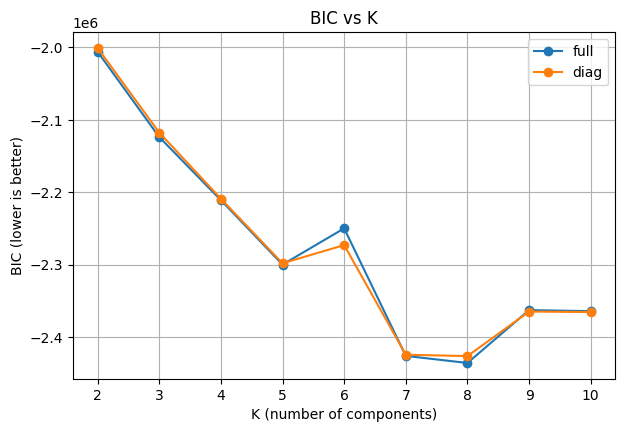

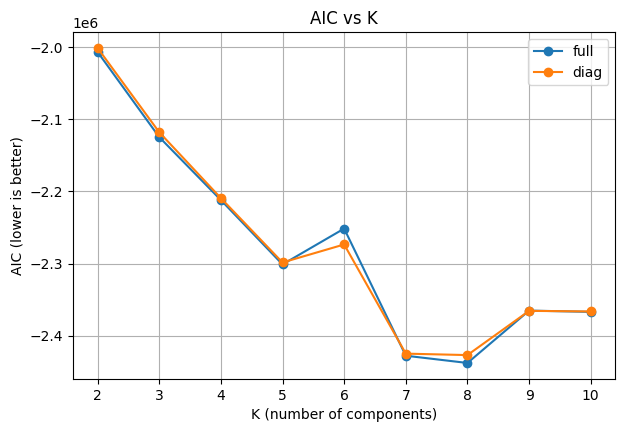

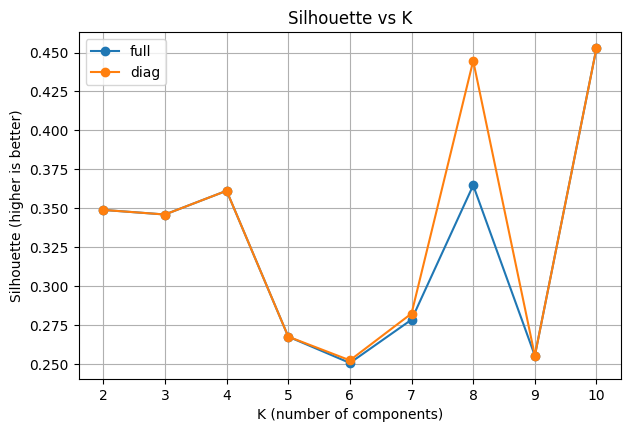

In [15]:
# GMM-2 | Model selection over K and covariance_type (full, diag)
# ----------------------------------------------------------------
# This cell:
# - Fits GaussianMixture for K in [2..10] and covariance_type in {"full","diag"}.
# - Records BIC, AIC, and Silhouette (using hard labels).
# - Plots BIC/AIC/Silhouette vs K for each covariance type.
# - Prints the best setting by BIC (lower is better).
#
# Requirements: X_scaled from previous cell.

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

assert 'X_scaled' in globals(), "X_scaled not found. Run the data prep cell first."

K_range = range(2, 11)
cov_types = ["full", "diag"]
random_state = 42
max_iter = 500
n_init = 3  # try multiple inits for stabler results

records = []

# For speed, compute silhouette on a (stratified-ish) subsample if n is large
n_samples = X_scaled.shape[0]
sil_n = min(10000, n_samples)
# Random permutation for sampling
rng = np.random.default_rng(random_state)
sample_idx = rng.choice(n_samples, size=sil_n, replace=False) if sil_n < n_samples else np.arange(n_samples)
X_sil = X_scaled[sample_idx]

for cov in cov_types:
    for k in K_range:
        try:
            gmm = GaussianMixture(
                n_components=k,
                covariance_type=cov,
                random_state=random_state,
                max_iter=max_iter,
                n_init=n_init,
                reg_covar=1e-6,
            ).fit(X_scaled)

            bic = gmm.bic(X_scaled)
            aic = gmm.aic(X_scaled)

            # Hard labels for silhouette
            labels = gmm.predict(X_scaled)
            # If fewer than 2 unique labels, silhouette is undefined
            if len(np.unique(labels)) < 2:
                sil = np.nan
            else:
                # map labels to the sampled subset for speed
                labels_sil = gmm.predict(X_sil)
                if len(np.unique(labels_sil)) < 2:
                    sil = np.nan
                else:
                    sil = silhouette_score(X_sil, labels_sil, metric="euclidean")

            records.append({
                "covariance_type": cov,
                "K": k,
                "BIC": bic,
                "AIC": aic,
                "Silhouette": sil
            })

        except Exception as e:
            records.append({
                "covariance_type": cov,
                "K": k,
                "BIC": np.nan,
                "AIC": np.nan,
                "Silhouette": np.nan,
                "error": str(e)
            })

results = pd.DataFrame.from_records(records)
display(results.sort_values(["covariance_type", "K"]).reset_index(drop=True))

# ---- Choose best by BIC (lower is better) ----
valid = results.dropna(subset=["BIC"])
best_row = valid.loc[valid["BIC"].idxmin()].to_dict() if len(valid) else None

if best_row:
    print("\nBest by BIC:")
    print(f"  covariance_type = {best_row['covariance_type']}")
    print(f"  K = {int(best_row['K'])}")
    print(f"  BIC = {best_row['BIC']:.2f}, AIC = {best_row['AIC']:.2f}, Silhouette = {best_row['Silhouette']:.4f}")
else:
    print("No valid GMM fit to select best model.")

# ---- Plots: BIC, AIC, Silhouette vs K ----
def plot_metric(metric_name, ylabel):
    plt.figure(figsize=(7, 4.5))
    for cov in cov_types:
        sub = results[(results["covariance_type"] == cov)].sort_values("K")
        plt.plot(sub["K"], sub[metric_name], marker="o", label=cov)
    plt.xlabel("K (number of components)")
    plt.ylabel(ylabel)
    plt.title(f"{metric_name} vs K")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric("BIC", "BIC (lower is better)")
plot_metric("AIC", "AIC (lower is better)")
plot_metric("Silhouette", "Silhouette (higher is better)")


In [17]:
# GMM-3 | Final model with K=8, covariance=full (fixed without artifacts)
# -----------------------------------------------------------------------
import pandas as pd
from sklearn.mixture import GaussianMixture

K_final = 8
cov_final = "full"
random_state = 42
max_iter = 500
n_init = 3

# 1) Fit final model
gmm_final = GaussianMixture(
    n_components=K_final,
    covariance_type=cov_final,
    random_state=random_state,
    max_iter=max_iter,
    n_init=n_init,
    reg_covar=1e-6,
).fit(X_scaled)

# 2) Predict cluster labels
labels_final = gmm_final.predict(X_scaled)

# Attach to original DataFrame
df_gmm = df.copy()
df_gmm["cluster_gmm"] = labels_final

# 3) Cluster sizes
cluster_sizes = df_gmm["cluster_gmm"].value_counts().sort_index()
print("Cluster sizes:")
print(cluster_sizes)

# 4) Define feature cols again (safe ones)
feature_cols = ["contributors",
                "isArchived","isFork","isPrivate",
                "hasIssuesEnabled","hasProjectsEnabled","hasWikiEnabled"]

# 5) Cluster profiles: summary statistics
profile = (
    df_gmm.groupby("cluster_gmm")[feature_cols]
    .agg(["mean","median","min","max"])
)

display(profile)

# Optional: quick numeric-only profile (mean)
profile_means = df_gmm.groupby("cluster_gmm")[feature_cols].mean()
display(profile_means.round(2))


Cluster sizes:
0     8234
1      895
2      553
3      344
4     4459
5     6230
6     1937
7    14468
Name: cluster_gmm, dtype: int64


contributors                 isArchived                       \
                    mean median min  max       mean median    min    max   
cluster_gmm                                                                
0               1.000000    1.0   1    1   0.000000    0.0  False  False   
1              14.850279    7.0   0  100   0.105028    0.0  False   True   
2              12.157324    4.0   0  100   0.253165    0.0  False   True   
3               6.718023    1.0   0  100   0.119186    0.0  False   True   
4               2.000000    2.0   2    2   0.000000    0.0  False  False   
5              15.972071    7.0   0  100   0.127127    0.0  False   True   
6              11.101187    5.0   0  100   1.000000    1.0   True   True   
7              12.891761    6.0   0  100   0.000000    0.0  False  False   

            isFork         ... hasIssuesEnabled        hasProjectsEnabled  \
              mean median  ...              min    max               mean   
cluster_gmm                ...                                              
0              0.0    0.0  ...             True   True           1.000000   
1              0.0    0.0  ...             True   True           0.000000   
2              0.0    0.0  ...            False  False           0.160940   
3              0.0    0.0  ...            False  False           0.898256   
4              0.0    0.0  ...             True   True           1.000000   
5              0.0    0.0  ...             True   True           0.389567   
6              0.0    0.0  ...             True   True           1.000000   
7              0.0    0.0  ...             True   True           1.000000   

                                 hasWikiEnabled                       
            median    min    max           mean median    min    max  
cluster_gmm                                                           
0              1.0   True   True            1.0    1.0   True   True  
1              0.0  False  False            1.0    1.0   True   True  
2              0.0  False   True            0.0    0.0  False  False  
3              1.0  False   True            1.0    1.0   True   True  
4              1.0   True   True            1.0    1.0   True   True  
5              0.0  False   True            0.0    0.0  False  False  
6              1.0   True   True            1.0    1.0   True   True  
7              1.0   True   True            1.0    1.0   True   True  

[8 rows x 28 columns]

,contributors,isArchived,isFork,isPrivate,hasIssuesEnabled,hasProjectsEnabled,hasWikiEnabled
cluster_gmm,,,,,,,
0,1.00,0.00,0.0,0.0,1.0,1.00,1.0
1,14.85,0.11,0.0,0.0,1.0,0.00,1.0
2,12.16,0.25,0.0,0.0,0.0,0.16,0.0
3,6.72,0.12,0.0,0.0,0.0,0.90,1.0
4,2.00,0.00,0.0,0.0,1.0,1.00,1.0
5,15.97,0.13,0.0,0.0,1.0,0.39,0.0
6,11.10,1.00,0.0,0.0,1.0,1.00,1.0
7,12.89,0.00,0.0,0.0,1.0,1.00,1.0


Perfect 👌 Here’s a clean **Markdown summary in English** for the 8 GMM clusters:

---

# GMM Clusters (K=8, covariance=full)

### Cluster 0 — **Solo Boilerplate Projects**

* **Size:** 8,234 repos
* **Contributors:** \~1 (always 1)
* **Settings:** Issues, Projects, Wiki → all enabled
* **Archived:** 0%
* **Insight:** Likely skeleton or demo repos, single-developer, all GitHub features turned on.

---

### Cluster 1 — **Active Team, Wiki-oriented**

* **Size:** 895 repos
* **Contributors:** \~15 (median \~7)
* **Settings:** Issues ON, Wiki ON, Projects rarely used
* **Archived:** \~10%
* **Insight:** Team projects that rely on Issues/Wiki, but not Projects.

---

### Cluster 2 — **Medium Teams, Mixed Activity**

* **Size:** 553 repos
* **Contributors:** \~12 (median \~4)
* **Settings:** Issues OFF, Projects \~16% ON, Wiki OFF
* **Archived:** \~25%
* **Insight:** Mid-size projects, some abandoned/archived, less consistent use of management features.

---

### Cluster 3 — **Structured Organizational Projects**

* **Size:** 344 repos
* **Contributors:** \~7 (median \~1)
* **Settings:** Projects \~90% ON, Wiki ON, Issues OFF
* **Archived:** \~12%
* **Insight:** Likely organizational repos that emphasize Projects & Wiki, not Issues.

---

### Cluster 4 — **Tiny 2-Person Teams**

* **Size:** 4,459 repos
* **Contributors:** \~2 (always 2)
* **Settings:** Issues, Projects, Wiki → all enabled
* **Archived:** 0%
* **Insight:** Very small teams, but GitHub features fully enabled.

---

### Cluster 5 — **Large Teams, Selective Features**

* **Size:** 6,230 repos
* **Contributors:** \~16 (median \~7)
* **Settings:** Issues ON, Projects \~39% ON, Wiki OFF
* **Archived:** \~13%
* **Insight:** Larger teams, more heterogeneous setups (some features disabled).

---

### Cluster 6 — **Archived Large Projects**

* **Size:** 1,937 repos
* **Contributors:** \~11 (median \~5)
* **Settings:** Issues, Projects, Wiki → all enabled
* **Archived:** 100%
* **Insight:** Big projects that have been completely archived — legacy or deprecated repos.

---

### Cluster 7 — **Mainstream Active Teams**

* **Size:** 14,468 repos (largest cluster)
* **Contributors:** \~13 (median \~6)
* **Settings:** Issues, Projects, Wiki → all enabled
* **Archived:** 0%
* **Insight:** The dominant cluster of “typical” active, collaborative projects.

---

👉 **Overall pattern:**

* Clusters 0 & 4 = very small projects (solo/2-person).
* Clusters 1,2,3,5,7 = active teams, differentiated by GitHub settings.
* Cluster 6 = uniquely “all archived” large projects.




In [21]:
# Supervised Modeling per Cluster | Target = contributors (fixed RMSE & feature selection)
# ---------------------------------------------------------------------------------------
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ---------- Setup ----------
target = "contributors"
clusters = sorted(df_gmm["cluster_gmm"].unique())
results = []

# Exclude targets and cluster
exclude_cols = [target, "cluster_gmm", "duration_days"]

# Keep only numeric/boolean (exclude object & datetime)
feature_cols = [
    c for c in df_gmm.columns
    if c not in exclude_cols
    and (pd.api.types.is_integer_dtype(df_gmm[c])
         or pd.api.types.is_float_dtype(df_gmm[c])
         or pd.api.types.is_bool_dtype(df_gmm[c]))
]

print("Using features:", feature_cols)

# ---------- Loop over clusters ----------
for cl in clusters:
    df_sub = df_gmm[df_gmm["cluster_gmm"] == cl].copy()

    # skip very small clusters
    if len(df_sub) < 50:
        continue

    X = df_sub[feature_cols].astype(float)  # ensure numeric
    y = df_sub[target].astype(float)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    models = {
        "Linear": LinearRegression(),
        "RF": RandomForestRegressor(
            n_estimators=200, random_state=42, n_jobs=-1
        ),
        "XGB": XGBRegressor(
            n_estimators=300, learning_rate=0.1,
            max_depth=6, subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, tree_method="auto"
        ),
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))  # <- fix

        results.append({
            "Cluster": cl,
            "Model": name,
            "Samples": len(df_sub),
            "R2": float(r2),
            "MAE": float(mae),
            "RMSE": float(rmse)
        })

# ---------- Results ----------
results_df = pd.DataFrame(results)
display(results_df.sort_values(["Cluster","Model"]).reset_index(drop=True))


Using features: ['stargazerCount', 'forkCount', 'diskUsage', 'isArchived', 'isEmpty', 'isFork', 'isInOrganization', 'isPrivate', 'isTemplate', 'hasIssuesEnabled', 'hasWikiEnabled', 'hasProjectsEnabled', 'hasSponsorshipsEnabled', 'mergeCommitAllowed', 'viewerCanSubscribe', 'issues', 'forks', 'assignableUsers', 'deployments', 'environments', 'milestones', 'releases', 'pullRequests', 'watchers', 'language_count']


,Cluster,Model,Samples,R2,MAE,RMSE
0,0,Linear,8234,1.000000,0.000000,0.000000
1,0,RF,8234,1.000000,0.000000,0.000000
2,0,XGB,8234,1.000000,0.000000,0.000000
3,1,Linear,895,0.341516,9.223919,14.059103
4,1,RF,895,0.499292,6.838855,12.259625
5,1,XGB,895,0.531556,6.735804,11.858068
6,2,Linear,553,0.109302,10.838936,18.671012
7,2,RF,553,0.084375,10.142703,18.930477
8,2,XGB,553,0.119079,10.099706,18.568262
9,3,Linear,344,0.610318,4.925991,9.710155


In [22]:
# Pivot tables for clearer view
r2_pivot = results_df.pivot(index="Cluster", columns="Model", values="R2")
mae_pivot = results_df.pivot(index="Cluster", columns="Model", values="MAE")
rmse_pivot = results_df.pivot(index="Cluster", columns="Model", values="RMSE")

print("R² by Cluster/Model")
display(r2_pivot.round(3))

print("MAE by Cluster/Model")
display(mae_pivot.round(2))

print("RMSE by Cluster/Model")
display(rmse_pivot.round(2))


R² by Cluster/Model


Model,Linear,RF,XGB
Cluster,,,
0,1.000,1.000,1.000
1,0.342,0.499,0.532
2,0.109,0.084,0.119
3,0.610,0.671,0.709
4,1.000,1.000,1.000
5,0.327,0.591,0.599
6,-0.896,0.667,0.661
7,0.255,0.613,0.623


MAE by Cluster/Model


Model,Linear,RF,XGB
Cluster,,,
0,0.00,0.00,0.00
1,9.22,6.84,6.74
2,10.84,10.14,10.10
3,4.93,3.69,3.58
4,0.00,0.00,0.00
5,11.04,7.71,7.77
6,8.52,5.05,5.20
7,8.41,5.81,5.82


RMSE by Cluster/Model


Model,Linear,RF,XGB
Cluster,,,
0,0.00,0.00,0.00
1,14.06,12.26,11.86
2,18.67,18.93,18.57
3,9.71,8.92,8.40
4,0.00,0.00,0.00
5,18.73,14.61,14.46
6,23.34,9.78,9.87
7,15.30,11.02,10.88




# Supervised Modeling Results (Target = `contributors`)

### Cluster 0 — **Trivial Solo Projects**

* **Samples:** 8,234
* **Results:** R²=1.00, MAE=0, RMSE=0 for all models
* **Reason:** All repos have exactly **1 contributor** → model just predicts a constant.

---

### Cluster 1 — **Active Teams (Wiki-oriented)**

* **Samples:** 895
* **Results:**

  * Linear: R² ≈ 0.34
  * RF: R² ≈ 0.50
  * XGB: R² ≈ 0.53 (best)
* **Error:** MAE \~7 contributors
* **Insight:** Tree-based models handle nonlinearity better; linear model underfits.

---

### Cluster 2 — **Medium Teams (Mixed/Noisy)**

* **Samples:** 553
* **Results:** R² \~0.08–0.12 (very low)
* **Error:** MAE \~10, RMSE \~18
* **Insight:** Highly noisy cluster, features don’t explain contributors well.

---

### Cluster 3 — **Structured Organizational Projects**

* **Samples:** 344
* **Results:**

  * Linear: R² ≈ 0.61
  * RF: R² ≈ 0.67
  * XGB: R² ≈ 0.71 (best)
* **Error:** MAE \~3.5–4.9
* **Insight:** Strong predictive power; features (Projects/Wiki enabled) align well with team size.

---

### Cluster 4 — **Trivial Two-Person Teams**

* **Samples:** 4,459
* **Results:** R²=1.00, MAE=0, RMSE=0 for all models
* **Reason:** All repos have exactly **2 contributors** → constant prediction.

---

### Cluster 5 — **Large Teams (Selective Features)**

* **Samples:** 6,230
* **Results:**

  * Linear: R² ≈ 0.33
  * RF: R² ≈ 0.59
  * XGB: R² ≈ 0.60 (best)
* **Error:** MAE \~7–11
* **Insight:** Tree-based models substantially outperform linear regression.

---

### Cluster 6 — **Archived Large Projects**

* **Samples:** 1,937
* **Results:**

  * Linear: R² = -0.89 (worse than mean baseline)
  * RF: R² ≈ 0.67
  * XGB: R² ≈ 0.66
* **Error:** MAE \~5, RMSE \~9–10
* **Insight:** Only nonlinear models succeed; cluster is predictable despite being archived.

---

### Cluster 7 — **Mainstream Active Teams**

* **Samples:** 14,468 (largest cluster)
* **Results:**

  * Linear: R² ≈ 0.25
  * RF: R² ≈ 0.61
  * XGB: R² ≈ 0.62 (best)
* **Error:** MAE \~6–8
* **Insight:** Large, active teams can be modeled fairly well with tree-based methods.

---

## ✨ Overall Insights

* **Trivial clusters (0 & 4):** Perfect prediction since contributors are constant.
* **Well-structured clusters (3, 6, 7):** Strong results with RF/XGB (R² \~0.6–0.7).
* **Noisy cluster (2):** Poor predictability; features weakly correlated with contributors.
* **Model comparison:**

  * **Linear Regression:** weaker, except in cluster 3.
  * **Random Forest & XGB:** consistently better across most clusters.

👉 Conclusion:
`contributors` is a **useful proxy for effort**, especially when clustering separates different repo types.
Tree-based models (RF/XGB) provide the best balance of accuracy and robustness.


